In [2]:
!pip install transformers torch datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 46.8 MB/s eta 0:00:00


In [4]:
!pip install tqdm


In [5]:
import torch
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from datasets import load_dataset, Dataset
import pandas as pd



# Define tokenizers and models using Auto classes
chem_tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MLM")
chem_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MLM")

prot_tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd")
prot_model = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

In [ ]:
# Combine SMILES and protein sequence tokenizers with prompt engineering
def tokenize_function(examples):
    smiles = examples['smiles']
    protein_sequence = examples['protein_sequence']

    # Create prompts
    prompts = [f"Given the SMILES: {smi} and the protein sequence: {prot}, predict the Ki value."
               for smi, prot in zip(smiles, protein_sequence)]

    # Tokenize the prompts
    prompt_tokens = chem_tokenizer(prompts, truncation=True, padding='max_length', max_length=512, return_tensors="pt")

    # Tokenize protein sequence
    protein_tokens = prot_tokenizer(protein_sequence, truncation=True, padding='max_length', max_length=512, return_tensors="pt")

    # Combine the input_ids and attention_mask from both tokenizations
    combined_input_ids = torch.cat([prompt_tokens['input_ids'], protein_tokens['input_ids']], dim=1)
    combined_attention_mask = torch.cat([prompt_tokens['attention_mask'], protein_tokens['attention_mask']], dim=1)

    return {
        'input_ids': combined_input_ids.squeeze(),
        'attention_mask': combined_attention_mask.squeeze(),
        'ki_value': examples['ki_value']  # Ki values as targets
    }

# Convert the dataframe to a Huggingface dataset
# Load the dataset from the CSV file (adapt to your format)
data_path = "/content/output.csv"  # Replace with your file path
df = pd.read_csv(data_path)
dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle().select([i for i in range(10000)])


# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns (if present)
tokenized_dataset = tokenized_dataset.remove_columns(['compound_id', 'target_id', 'protein_sequence', 'smiles'])


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# Print the first few examples in the tokenized dataset
for i in range(5):  # Adjust the range for more or fewer examples
    print(f"Example {i+1}:")
    print("Input IDs:", tokenized_dataset[i]['input_ids'])
    print("Attention Mask:", tokenized_dataset[i]['attention_mask'])
    print("Ki Value:", tokenized_dataset[i]['ki_value'])
    print("-" * 50)


Example 1:
Input IDs: [12, 25, 34, 48, 34, 16, 20, 22, 16, 16, 17, 22, 16, 21, 16, 17, 22, 16, 20, 18, 23, 23, 22, 16, 21, 23, 18, 16, 26, 22, 16, 16, 22, 16, 17, 16, 22, 16, 26, 18, 23, 16, 17, 22, 19, 18, 23, 16, 32, 22, 16, 17, 16, 22, 16, 16, 17, 22, 16, 32, 18, 16, 17, 22, 19, 18, 19, 18, 27, 25, 206, 44, 25, 42, 25, 15, 16, 27, 16, 27, 45, 23, 48, 23, 45, 48, 34, 16, 23, 34, 23, 23, 48, 27, 48, 27, 16, 23, 34, 27, 45, 34, 34, 16, 27, 23, 34, 23, 27, 27, 48, 48, 45, 48, 34, 34, 27, 23, 34, 45, 27, 27, 48, 16, 34, 16, 45, 27, 45, 48, 34, 45, 34, 16, 45, 45, 45, 16, 45, 48, 16, 16, 16, 16, 34, 45, 27, 27, 27, 34, 34, 45, 16, 16, 45, 45, 34, 45, 34, 16, 16, 27, 27, 45, 45, 34, 45, 16, 45, 45, 34, 45, 45, 45, 34, 48, 34, 16, 16, 45, 34, 16, 45, 16, 34, 34, 45, 45, 34, 34, 45, 23, 27, 23, 34, 34, 34, 27, 34, 34, 48, 23, 45, 45, 34, 34, 34, 34, 34, 48, 45, 45, 45, 34, 34, 23, 34, 23, 27, 34, 45, 34, 27, 34, 45, 34, 23, 48, 27, 27, 48, 23, 34, 45, 27, 34, 34, 45, 45, 45, 23, 27, 48, 45, 

In [ ]:
from torch.utils.data import DataLoader
import torch

# Convert Hugging Face dataset to PyTorch DataLoader
def collate_fn(batch):
    # Collate function to batch data for DataLoader
    input_ids = torch.tensor([item['input_ids'] for item in batch])  # Convert list to tensor
    attention_mask = torch.tensor([item['attention_mask'] for item in batch])  # Convert list to tensor
    ki_values = torch.tensor([item['ki_value'] for item in batch], dtype=torch.float)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'ki_value': ki_values}

batch_size = 16  # Adjust as necessary
dataloader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)


In [ ]:
from transformers import RobertaTokenizer, BertTokenizer
from datasets import Dataset
import pandas as pd
import torch

# Load tokenizers for SMILES and protein sequence
chem_tokenizer = RobertaTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MLM")
prot_tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert_bfd')

# Define the tokenization function
def tokenize_function(examples):
    smiles = examples['smiles']
    protein_sequence = examples['protein_sequence']

    # Create prompts for SMILES and protein sequence
    prompts = [f"Given the SMILES: {smi} and the protein sequence: {prot}, predict the Ki value."
               for smi, prot in zip(smiles, protein_sequence)]

    # Tokenize SMILES and protein sequence
    prompt_tokens = chem_tokenizer(prompts, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
    protein_tokens = prot_tokenizer(protein_sequence, truncation=True, padding='max_length', max_length=512, return_tensors="pt")

    # Combine input_ids and attention_mask from both tokenizations
    combined_input_ids = torch.cat([prompt_tokens['input_ids'], protein_tokens['input_ids']], dim=1)
    combined_attention_mask = torch.cat([prompt_tokens['attention_mask'], protein_tokens['attention_mask']], dim=1)

    return {
        'input_ids': combined_input_ids.squeeze(),
        'attention_mask': combined_attention_mask.squeeze(),
        'ki_value': examples['ki_value']  # Ki values as targets
    }

# Load dataset
data_path = "/content/output.csv"  # Replace with your file path
df = pd.read_csv(data_path)

# Convert the dataframe to a Huggingface dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle().select([i for i in range(10000)])

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns
tokenized_dataset = tokenized_dataset.remove_columns(['compound_id', 'target_id', 'protein_sequence', 'smiles'])


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset
from tqdm import tqdm  # Import tqdm for the progress bar

# Define DataLoader to handle batching
class KiDataset(TorchDataset):
    def __init__(self, dataset):
        self.input_ids = dataset['input_ids']
        self.attention_mask = dataset['attention_mask']
        self.ki_value = dataset['ki_value']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'ki_value': torch.tensor(self.ki_value[idx], dtype=torch.float)
        }

# Prepare DataLoader
batch_size = 32
train_dataset = KiDataset(tokenized_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define ANN Model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(2048, 1024)  # Input size 2048 due to SMILES and protein sequence concatenation
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)  # Output a single value for Ki prediction

    def forward(self, input_ids, attention_mask):
        # Concatenate input_ids and attention_mask
        x = torch.cat((input_ids, attention_mask), dim=1)

        # Convert to float32 before passing through the linear layers
        x = x.float()

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANNModel().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop with progress bar
epochs = 3  # You can change the number of epochs as needed
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    # Use tqdm to add a progress bar
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{epochs}")

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ki_values = batch['ki_value'].to(device)

            # Forward pass
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(input_ids, attention_mask)

            # Compute loss
            loss = criterion(outputs.squeeze(), ki_values)
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the progress bar with the current loss
            tepoch.set_postfix(loss=loss.item())

    # Print average training loss for this epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

# Save the model after training
torch.save(model.state_dict(), 'ki_prediction_model.pth')


Epoch 1/3: 100%|██████████| 313/313 [00:18<00:00, 17.35batch/s, loss=0.665]


Epoch 1/3, Average Loss: 4.8629


Epoch 2/3: 100%|██████████| 313/313 [00:19<00:00, 15.94batch/s, loss=1.29]


Epoch 2/3, Average Loss: 1.0005


Epoch 3/3: 100%|██████████| 313/313 [00:17<00:00, 17.66batch/s, loss=1.18]


Epoch 3/3, Average Loss: 0.8855


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert true_values and predicted_values to numpy arrays
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(true_values, color='green', label='True Ki Values')
plt.plot(predicted_values, color='blue', linestyle='--', label='Predicted Ki Values')

plt.xlabel('Data Points')
plt.ylabel('Ki Values')
plt.title('True vs Predicted Ki Values')
plt.legend()
plt.show()


NameError: name 'true_values' is not defined

In [6]:
from transformers import RobertaTokenizer, BertTokenizer
from datasets import Dataset
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Load tokenizers for SMILES and protein sequence
chem_tokenizer = RobertaTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MLM")
prot_tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert_bfd')

# Define the tokenization function
def tokenize_function(examples):
    smiles = examples['smiles']
    protein_sequence = examples['protein_sequence']

    # Create prompts for SMILES and protein sequence
    prompts = [f"Given the SMILES: {smi} and the protein sequence: {prot}, predict the Ki value."
               for smi, prot in zip(smiles, protein_sequence)]

    # Tokenize SMILES and protein sequence
    prompt_tokens = chem_tokenizer(prompts, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
    protein_tokens = prot_tokenizer(protein_sequence, truncation=True, padding='max_length', max_length=512, return_tensors="pt")

    # Combine input_ids and attention_mask from both tokenizations
    combined_input_ids = torch.cat([prompt_tokens['input_ids'], protein_tokens['input_ids']], dim=1)
    combined_attention_mask = torch.cat([prompt_tokens['attention_mask'], protein_tokens['attention_mask']], dim=1)

    return {
        'input_ids': combined_input_ids.squeeze(),
        'attention_mask': combined_attention_mask.squeeze(),
        'ki_value': examples['ki_value']  # Ki values as targets
    }

# Load dataset
data_path = "/content/output.csv"  # Replace with your file path
df = pd.read_csv(data_path)

# Limit to 10000 rows for testing
df = df.head(50000)

# Split dataset into training and test (validation) sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert the dataframes to Huggingface datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(['compound_id', 'target_id', 'protein_sequence', 'smiles'])
test_dataset = test_dataset.remove_columns(['compound_id', 'target_id', 'protein_sequence', 'smiles'])

# Print a sample to confirm tokenization
print(train_dataset[0])  # Check the first tokenized example in the training set


model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

{'ki_value': 12.599996932, '__index_level_0__': 39087, 'input_ids': [12, 11, 11, 11, 11, 25, 11, 11, 11, 11, 11, 34, 11, 48, 11, 11, 34, 11, 11, 16, 16, 20, 22, 16, 23, 22, 16, 17, 23, 22, 16, 20, 23, 16, 21, 22, 16, 16, 22, 16, 17, 16, 22, 16, 21, 18, 19, 16, 16, 17, 22, 19, 18, 23, 18, 23, 16, 26, 22, 16, 16, 17, 22, 16, 16, 22, 16, 26, 18, 34, 17, 22, 19, 18, 17, 22, 19, 18, 23, 11, 11, 25, 11, 11, 11, 11, 11, 11, 206, 11, 44, 11, 11, 11, 25, 11, 42, 11, 11, 11, 11, 25, 15, 11, 11, 11, 11, 11, 45, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 48, 45, 11, 48, 11, 45, 34, 11, 45, 11, 11, 11, 11, 11, 45, 11, 11, 11, 11, 11, 11, 11, 16, 11, 11, 23, 11, 34, 11, 11, 11, 11, 11, 45, 45, 34, 45, 11, 11, 11, 11, 11, 34, 11, 11, 34, 34, 34, 48, 11, 34, 11, 23, 23, 11, 11, 27, 11, 23, 11, 11, 11, 11, 11, 16, 11, 11, 45, 11, 11, 45, 11, 11, 11, 34, 11, 11, 48, 11, 11, 11, 11, 11, 11, 45, 11, 11, 45, 11, 23, 11, 11, 11, 11, 11, 11, 11, 11, 27, 11, 11, 11, 11, 11, 11, 11, 45, 16

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset
from tqdm import tqdm
import numpy as np  # For RMSE calculation

# Define DataLoader to handle batching
class KiDataset(TorchDataset):
    def __init__(self, dataset):
        self.input_ids = dataset['input_ids']
        self.attention_mask = dataset['attention_mask']
        self.ki_value = dataset['ki_value']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'ki_value': torch.tensor(self.ki_value[idx], dtype=torch.float)
        }

# Prepare DataLoader
batch_size = 32
train_dataloader = DataLoader(KiDataset(train_dataset), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(KiDataset(test_dataset), batch_size=batch_size, shuffle=False)

# Define ANN Model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(2048, 1024)  # Initial layer
        self.fc2 = nn.Linear(1024, 512)  # Additional layer
        self.fc3 = nn.Linear(512, 256)   # New additional layer
        self.fc4 = nn.Linear(256, 128)   # New additional layer
        self.fc5 = nn.Linear(128, 64)    # New additional layer
        self.fc6 = nn.Linear(64, 1)      # Final output layer for Ki prediction

    def forward(self, input_ids, attention_mask):
        # Concatenate input_ids and attention_mask
        x = torch.cat((input_ids, attention_mask), dim=1)

        # Convert to float32 before passing through the linear layers
        x = x.float()

        # Pass through the layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)  # Output layer without activation
        return x

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANNModel().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Function to calculate RMSE
def calculate_rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

# Variables to accumulate RMSE over all epochs
total_train_rmse = 0
total_test_rmse = 0
total_train_samples = 0
total_test_samples = 0

# Training loop with progress bar
epochs = 3  # You can change the number of epochs as needed
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    # Training phase with tqdm progress bar
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{epochs}")

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ki_values = batch['ki_value'].to(device)

            # Forward pass
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(input_ids, attention_mask)

            # Compute loss
            loss = criterion(outputs.squeeze(), ki_values)
            total_loss += loss.item()

            # Compute RMSE for training
            train_rmse = calculate_rmse(outputs.squeeze(), ki_values)
            total_train_rmse += train_rmse.item() * input_ids.size(0)  # Weighted by batch size
            total_train_samples += input_ids.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the progress bar with the current loss
            tepoch.set_postfix(loss=loss.item())

    # Print average training loss for this epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_loss:.4f}")

    # Testing phase
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ki_values = batch['ki_value'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Compute loss
            loss = criterion(outputs.squeeze(), ki_values)
            total_test_loss += loss.item()

            # Compute RMSE for testing
            test_rmse = calculate_rmse(outputs.squeeze(), ki_values)
            total_test_rmse += test_rmse.item() * input_ids.size(0)  # Weighted by batch size
            total_test_samples += input_ids.size(0)

    avg_test_loss = total_test_loss / len(test_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Test Loss: {avg_test_loss:.4f}")

# Calculate final RMSE after all epochs
final_train_rmse = total_train_rmse / total_train_samples
final_test_rmse = total_test_rmse / total_test_samples

# Print the final RMSE values
print(f"Final Training RMSE: {final_train_rmse:.4f}")
print(f"Final Test RMSE: {final_test_rmse:.4f}")

# Save the model after training
torch.save(model.state_dict(), 'ki_prediction_model.pth')


Epoch 1/3: 100%|██████████| 1250/1250 [01:16<00:00, 16.43batch/s, loss=0.745]


Epoch 1/3, Average Training Loss: 8.4862
Epoch 1/3, Average Test Loss: 0.6937


Epoch 2/3: 100%|██████████| 1250/1250 [01:17<00:00, 16.16batch/s, loss=0.387]


Epoch 2/3, Average Training Loss: 0.6615
Epoch 2/3, Average Test Loss: 0.6367


Epoch 3/3: 100%|██████████| 1250/1250 [01:17<00:00, 16.04batch/s, loss=0.308]


Epoch 3/3, Average Training Loss: 0.6038
Epoch 3/3, Average Test Loss: 0.6252
Final Training RMSE: 1.0505
Final Test RMSE: 0.7939


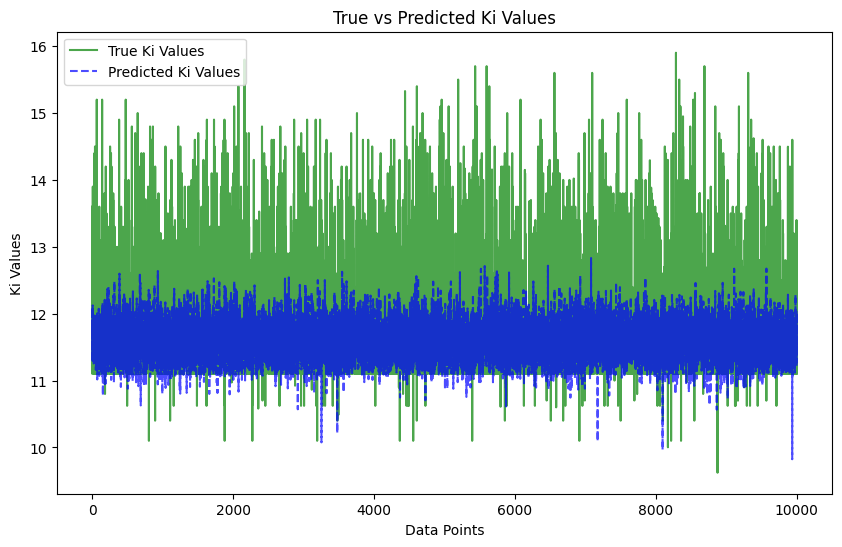

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define lists to store true and predicted Ki values
true_values = []
predicted_values = []

# Testing phase to collect true and predicted Ki values
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for evaluation
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        ki_values = batch['ki_value'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)

        # Collect true and predicted values
        true_values.extend(ki_values.cpu().numpy())  # Convert to CPU and numpy
        predicted_values.extend(outputs.squeeze().cpu().numpy())  # Convert to CPU and numpy

# Convert to numpy arrays for plotting
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)

# Plotting the true vs predicted Ki values
plt.figure(figsize=(10, 6))
plt.plot(true_values, color='green', label='True Ki Values', alpha=0.7)
plt.plot(predicted_values, color='blue', linestyle='--', label='Predicted Ki Values', alpha=0.7)

plt.xlabel('Data Points')
plt.ylabel('Ki Values')
plt.title('True vs Predicted Ki Values')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset
from tqdm import tqdm
import numpy as np  # For RMSE calculation

# Define DataLoader to handle batching
class KiDataset(TorchDataset):
    def __init__(self, dataset):
        self.input_ids = dataset['input_ids']
        self.attention_mask = dataset['attention_mask']
        self.ki_value = dataset['ki_value']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'ki_value': torch.tensor(self.ki_value[idx], dtype=torch.float)
        }

# Prepare DataLoader
batch_size = 32
train_dataloader = DataLoader(KiDataset(train_dataset), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(KiDataset(test_dataset), batch_size=batch_size, shuffle=False)

# Define a more complex ANN Model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()

        # SMILES pathway
        self.smiles_fc1 = nn.Linear(1024, 2048)
        self.smiles_bn1 = nn.BatchNorm1d(2048)
        self.smiles_fc2 = nn.Linear(2048, 1024)
        self.smiles_bn2 = nn.BatchNorm1d(1024)
        self.smiles_fc3 = nn.Linear(1024, 512)
        self.smiles_bn3 = nn.BatchNorm1d(512)
        self.smiles_fc4 = nn.Linear(512, 256)
        self.smiles_bn4 = nn.BatchNorm1d(256)

        # Protein sequence pathway
        self.protein_fc1 = nn.Linear(1024, 2048)
        self.protein_bn1 = nn.BatchNorm1d(2048)
        self.protein_fc2 = nn.Linear(2048, 1024)
        self.protein_bn2 = nn.BatchNorm1d(1024)
        self.protein_fc3 = nn.Linear(1024, 512)
        self.protein_bn3 = nn.BatchNorm1d(512)
        self.protein_fc4 = nn.Linear(512, 256)
        self.protein_bn4 = nn.BatchNorm1d(256)

        # Combined pathway
        self.combined_fc1 = nn.Linear(512, 512)
        self.combined_bn1 = nn.BatchNorm1d(512)
        self.combined_fc2 = nn.Linear(512, 256)
        self.combined_bn2 = nn.BatchNorm1d(256)
        self.combined_fc3 = nn.Linear(256, 128)
        self.combined_bn3 = nn.BatchNorm1d(128)
        self.combined_fc4 = nn.Linear(128, 64)
        self.combined_bn4 = nn.BatchNorm1d(64)
        self.combined_fc5 = nn.Linear(64, 1)

        # Dropout
        self.dropout = nn.Dropout(0.001)

    def forward(self, smiles_input, protein_input):
        # Convert to float for compatibility with linear layers
        smiles_input = smiles_input.float()
        protein_input = protein_input.float()

        # SMILES pathway
        x1 = torch.relu(self.smiles_fc1(smiles_input))
        x1 = self.smiles_bn1(x1)
        x1 = self.dropout(torch.relu(self.smiles_fc2(x1)))
        x1 = self.smiles_bn2(x1)
        x1 = self.dropout(torch.relu(self.smiles_fc3(x1)))
        x1 = self.smiles_bn3(x1)
        x1 = self.dropout(torch.relu(self.smiles_fc4(x1)))
        x1 = self.smiles_bn4(x1)

        # Protein sequence pathway
        x2 = torch.relu(self.protein_fc1(protein_input))
        x2 = self.protein_bn1(x2)
        x2 = self.dropout(torch.relu(self.protein_fc2(x2)))
        x2 = self.protein_bn2(x2)
        x2 = self.dropout(torch.relu(self.protein_fc3(x2)))
        x2 = self.protein_bn3(x2)
        x2 = self.dropout(torch.relu(self.protein_fc4(x2)))
        x2 = self.protein_bn4(x2)

        # Concatenate pathways
        x = torch.cat((x1, x2), dim=1)

        # Combined pathway
        x = torch.relu(self.combined_fc1(x))
        x = self.combined_bn1(x)
        x = self.dropout(torch.relu(self.combined_fc2(x)))
        x = self.combined_bn2(x)
        x = self.dropout(torch.relu(self.combined_fc3(x)))
        x = self.combined_bn3(x)
        x = self.dropout(torch.relu(self.combined_fc4(x)))
        x = self.combined_bn4(x)
        x = self.combined_fc5(x)

        return x


# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANNModel().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Function to calculate RMSE
def calculate_rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

# Variables to accumulate RMSE over all epochs
total_train_rmse = 0
total_test_rmse = 0
total_train_samples = 0
total_test_samples = 0

# Training loop with progress bar
epochs = 3  # You can change the number of epochs as needed
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    # Training phase with tqdm progress bar
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{epochs}")

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ki_values = batch['ki_value'].to(device)

            # Forward pass
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(input_ids, attention_mask)

            # Compute loss
            loss = criterion(outputs.squeeze(), ki_values)
            total_loss += loss.item()

            # Compute RMSE for training
            train_rmse = calculate_rmse(outputs.squeeze(), ki_values)
            total_train_rmse += train_rmse.item() * input_ids.size(0)  # Weighted by batch size
            total_train_samples += input_ids.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the progress bar with the current loss
            tepoch.set_postfix(loss=loss.item())

    # Print average training loss for this epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_loss:.4f}")

    # Testing phase
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ki_values = batch['ki_value'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Compute loss
            loss = criterion(outputs.squeeze(), ki_values)
            total_test_loss += loss.item()

            # Compute RMSE for testing
            test_rmse = calculate_rmse(outputs.squeeze(), ki_values)
            total_test_rmse += test_rmse.item() * input_ids.size(0)  # Weighted by batch size
            total_test_samples += input_ids.size(0)

    avg_test_loss = total_test_loss / len(test_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Test Loss: {avg_test_loss:.4f}")

# Calculate final RMSE after all epochs
final_train_rmse = total_train_rmse / total_train_samples
final_test_rmse = total_test_rmse / total_test_samples

# Print the final RMSE values
print(f"Final Training RMSE: {final_train_rmse:.4f}")
print(f"Final Test RMSE: {final_test_rmse:.4f}")

# Save the model after training
torch.save(model.state_dict(), 'ki_prediction_model.pth')


Epoch 1/3: 100%|██████████| 1250/1250 [03:23<00:00,  6.16batch/s, loss=138]


Epoch 1/3, Average Training Loss: 136.8724
Epoch 1/3, Average Test Loss: 133.7180


Epoch 2/3: 100%|██████████| 1250/1250 [03:20<00:00,  6.22batch/s, loss=136]


Epoch 2/3, Average Training Loss: 135.1131
Epoch 2/3, Average Test Loss: 133.6130


Epoch 3/3: 100%|██████████| 1250/1250 [03:26<00:00,  6.05batch/s, loss=138]


Epoch 3/3, Average Training Loss: 132.7355
Epoch 3/3, Average Test Loss: 127.6126
Final Training RMSE: 11.6139
Final Test RMSE: 11.4714


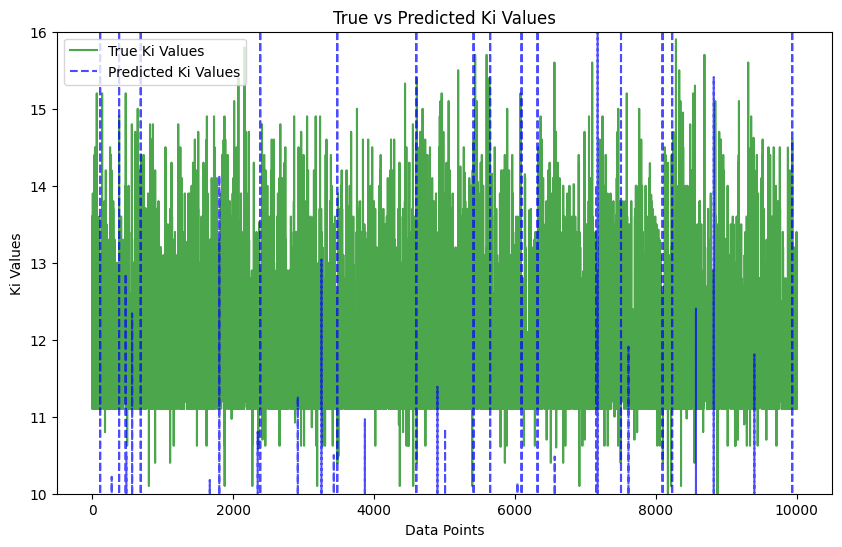

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define lists to store true and predicted Ki values
true_values = []
predicted_values = []

# Testing phase to collect true and predicted Ki values
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for evaluation
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        ki_values = batch['ki_value'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)

        # Collect true and predicted values
        true_values.extend(ki_values.cpu().numpy())  # Convert to CPU and numpy
        predicted_values.extend(outputs.squeeze().cpu().numpy())  # Convert to CPU and numpy

# Convert to numpy arrays for plotting
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)

# Plotting the true vs predicted Ki values
plt.figure(figsize=(10, 6))
plt.plot(true_values, color='green', label='True Ki Values', alpha=0.7)
plt.plot(predicted_values, color='blue', linestyle='--', label='Predicted Ki Values', alpha=0.7)

# Set the y-axis limit to be between 10 and 16
plt.ylim(10, 16)

plt.xlabel('Data Points')
plt.ylabel('Ki Values')
plt.title('True vs Predicted Ki Values')
plt.legend()
plt.show()


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset
from tqdm import tqdm
import numpy as np  # For RMSE calculation

# Define DataLoader to handle batching
class KiDataset(TorchDataset):
    def __init__(self, dataset):
        self.input_ids = dataset['input_ids']
        self.attention_mask = dataset['attention_mask']
        self.ki_value = dataset['ki_value']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'ki_value': torch.tensor(self.ki_value[idx], dtype=torch.float)
        }

# Prepare DataLoader
batch_size = 32
train_dataloader = DataLoader(KiDataset(train_dataset), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(KiDataset(test_dataset), batch_size=batch_size, shuffle=False)

# Define ANN Model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(2048, 1024)  # Initial layer
        self.fc2 = nn.Linear(1024, 768)   # New additional layer
        self.fc3 = nn.Linear(768, 512)    # Additional layer
        self.fc4 = nn.Linear(512, 384)    # New additional layer
        self.fc5 = nn.Linear(384, 256)    # Additional layer
        self.fc6 = nn.Linear(256, 192)    # New additional layer
        self.fc7 = nn.Linear(192, 128)    # Additional layer
        self.fc8 = nn.Linear(128, 96)     # New additional layer
        self.fc9 = nn.Linear(96, 64)      # Additional layer
        self.fc10 = nn.Linear(64, 1)      # Final output layer for Ki prediction

    def forward(self, input_ids, attention_mask):
        # Concatenate input_ids and attention_mask
        x = torch.cat((input_ids, attention_mask), dim=1)

        # Convert to float32 before passing through the linear layers
        x = x.float()

        # Pass through the layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = torch.relu(self.fc9(x))
        x = self.fc10(x)  # Output layer without activation

        return x

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANNModel().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Function to calculate RMSE
def calculate_rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

# Variables to accumulate RMSE over all epochs
total_train_rmse = 0
total_test_rmse = 0
total_train_samples = 0
total_test_samples = 0

# Training loop with progress bar
epochs = 3  # You can change the number of epochs as needed
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    # Training phase with tqdm progress bar
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{epochs}")

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ki_values = batch['ki_value'].to(device)

            # Forward pass
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(input_ids, attention_mask)

            # Compute loss
            loss = criterion(outputs.squeeze(), ki_values)
            total_loss += loss.item()

            # Compute RMSE for training
            train_rmse = calculate_rmse(outputs.squeeze(), ki_values)
            total_train_rmse += train_rmse.item() * input_ids.size(0)  # Weighted by batch size
            total_train_samples += input_ids.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the progress bar with the current loss
            tepoch.set_postfix(loss=loss.item())

    # Print average training loss for this epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_loss:.4f}")

    # Testing phase
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ki_values = batch['ki_value'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Compute loss
            loss = criterion(outputs.squeeze(), ki_values)
            total_test_loss += loss.item()

            # Compute RMSE for testing
            test_rmse = calculate_rmse(outputs.squeeze(), ki_values)
            total_test_rmse += test_rmse.item() * input_ids.size(0)  # Weighted by batch size
            total_test_samples += input_ids.size(0)

    avg_test_loss = total_test_loss / len(test_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Test Loss: {avg_test_loss:.4f}")

# Calculate final RMSE after all epochs
final_train_rmse = total_train_rmse / total_train_samples
final_test_rmse = total_test_rmse / total_test_samples

# Print the final RMSE values
print(f"Final Training RMSE: {final_train_rmse:.4f}")
print(f"Final Test RMSE: {final_test_rmse:.4f}")

# Save the model after training
torch.save(model.state_dict(), 'ki_prediction_model.pth')


Epoch 1/3: 100%|██████████| 1250/1250 [01:40<00:00, 12.45batch/s, loss=0.385]


Epoch 1/3, Average Training Loss: 15.2022
Epoch 1/3, Average Test Loss: 0.6949


Epoch 2/3: 100%|██████████| 1250/1250 [01:47<00:00, 11.65batch/s, loss=0.443]


Epoch 2/3, Average Training Loss: 0.6688
Epoch 2/3, Average Test Loss: 0.6709


Epoch 3/3: 100%|██████████| 1250/1250 [01:47<00:00, 11.59batch/s, loss=1.01]


Epoch 3/3, Average Training Loss: 0.6271
Epoch 3/3, Average Test Loss: 0.6180
Final Training RMSE: 1.2231
Final Test RMSE: 0.8025


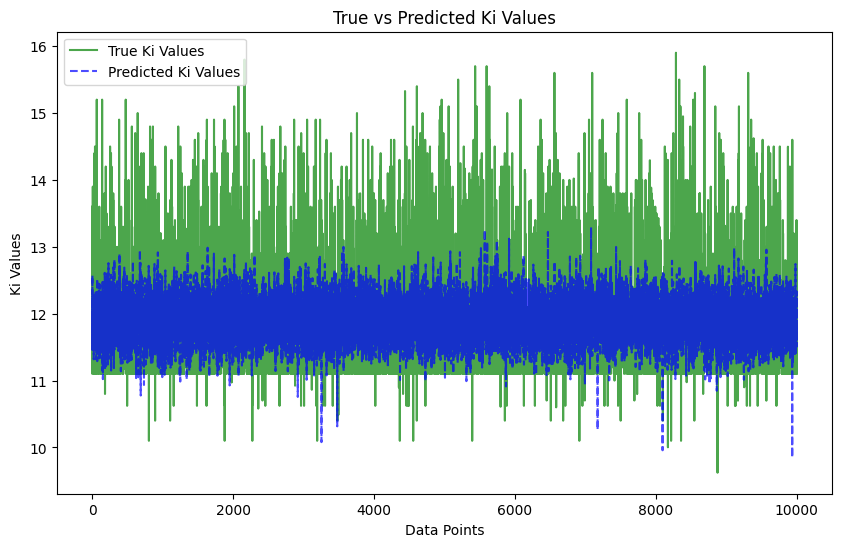

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define lists to store true and predicted Ki values
true_values = []
predicted_values = []

# Testing phase to collect true and predicted Ki values
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for evaluation
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        ki_values = batch['ki_value'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)

        # Collect true and predicted values
        true_values.extend(ki_values.cpu().numpy())  # Convert to CPU and numpy
        predicted_values.extend(outputs.squeeze().cpu().numpy())  # Convert to CPU and numpy

# Convert to numpy arrays for plotting
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)

# Plotting the true vs predicted Ki values
plt.figure(figsize=(10, 6))
plt.plot(true_values, color='green', label='True Ki Values', alpha=0.7)
plt.plot(predicted_values, color='blue', linestyle='--', label='Predicted Ki Values', alpha=0.7)

plt.xlabel('Data Points')
plt.ylabel('Ki Values')
plt.title('True vs Predicted Ki Values')
plt.legend()
plt.show()


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset
from tqdm import tqdm
import numpy as np  # For RMSE calculation

# Define DataLoader to handle batching
class KiDataset(TorchDataset):
    def __init__(self, dataset):
        self.input_ids = dataset['input_ids']
        self.attention_mask = dataset['attention_mask']
        self.ki_value = dataset['ki_value']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'ki_value': torch.tensor(self.ki_value[idx], dtype=torch.float)
        }

# Prepare DataLoader
batch_size = 32
train_dataloader = DataLoader(KiDataset(train_dataset), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(KiDataset(test_dataset), batch_size=batch_size, shuffle=False)

# Define ANN Model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(2048, 1024)   # Initial layer
        self.fc2 = nn.Linear(1024, 896)    # New additional layer
        self.fc3 = nn.Linear(896, 768)     # Additional layer
        self.fc4 = nn.Linear(768, 640)     # New additional layer
        self.fc5 = nn.Linear(640, 512)     # Additional layer
        self.fc6 = nn.Linear(512, 384)     # New additional layer
        self.fc7 = nn.Linear(384, 320)     # Additional layer
        self.fc8 = nn.Linear(320, 256)     # New additional layer
        self.fc9 = nn.Linear(256, 192)     # Additional layer
        self.fc10 = nn.Linear(192, 128)    # New additional layer
        self.fc11 = nn.Linear(128, 96)     # Additional layer
        self.fc12 = nn.Linear(96, 64)      # New additional layer
        self.fc13 = nn.Linear(64, 32)      # New additional layer
        self.fc14 = nn.Linear(32, 16)      # New additional layer
        self.fc15 = nn.Linear(16, 1)       # Final output layer for Ki prediction

    def forward(self, input_ids, attention_mask):
        # Concatenate input_ids and attention_mask
        x = torch.cat((input_ids, attention_mask), dim=1)

        # Convert to float32 before passing through the linear layers
        x = x.float()

        # Pass through the layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = torch.relu(self.fc9(x))
        x = torch.relu(self.fc10(x))
        x = torch.relu(self.fc11(x))
        x = torch.relu(self.fc12(x))
        x = torch.relu(self.fc13(x))
        x = torch.relu(self.fc14(x))
        x = self.fc15(x)  # Output layer without activation

        return x

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANNModel().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Function to calculate RMSE
def calculate_rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

# Variables to accumulate RMSE over all epochs
total_train_rmse = 0
total_test_rmse = 0
total_train_samples = 0
total_test_samples = 0

# Training loop with progress bar
epochs = 3  # You can change the number of epochs as needed
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    # Training phase with tqdm progress bar
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{epochs}")

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ki_values = batch['ki_value'].to(device)

            # Forward pass
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(input_ids, attention_mask)

            # Compute loss
            loss = criterion(outputs.squeeze(), ki_values)
            total_loss += loss.item()

            # Compute RMSE for training
            train_rmse = calculate_rmse(outputs.squeeze(), ki_values)
            total_train_rmse += train_rmse.item() * input_ids.size(0)  # Weighted by batch size
            total_train_samples += input_ids.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the progress bar with the current loss
            tepoch.set_postfix(loss=loss.item())

    # Print average training loss for this epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_loss:.4f}")

    # Testing phase
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ki_values = batch['ki_value'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Compute loss
            loss = criterion(outputs.squeeze(), ki_values)
            total_test_loss += loss.item()

            # Compute RMSE for testing
            test_rmse = calculate_rmse(outputs.squeeze(), ki_values)
            total_test_rmse += test_rmse.item() * input_ids.size(0)  # Weighted by batch size
            total_test_samples += input_ids.size(0)

    avg_test_loss = total_test_loss / len(test_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Test Loss: {avg_test_loss:.4f}")

# Calculate final RMSE after all epochs
final_train_rmse = total_train_rmse / total_train_samples
final_test_rmse = total_test_rmse / total_test_samples

# Print the final RMSE values
print(f"Final Training RMSE: {final_train_rmse:.4f}")
print(f"Final Test RMSE: {final_test_rmse:.4f}")

# Save the model after training
torch.save(model.state_dict(), 'ki_prediction_model.pth')


Epoch 1/3: 100%|██████████| 1250/1250 [02:15<00:00,  9.20batch/s, loss=0.389]


Epoch 1/3, Average Training Loss: 22.6792
Epoch 1/3, Average Test Loss: 0.7400


Epoch 2/3: 100%|██████████| 1250/1250 [02:33<00:00,  8.14batch/s, loss=0.771]


Epoch 2/3, Average Training Loss: 0.7030
Epoch 2/3, Average Test Loss: 0.7101


Epoch 3/3: 100%|██████████| 1250/1250 [02:33<00:00,  8.15batch/s, loss=0.629]


Epoch 3/3, Average Training Loss: 0.6627
Epoch 3/3, Average Test Loss: 0.6444
Final Training RMSE: 1.4235
Final Test RMSE: 0.8249


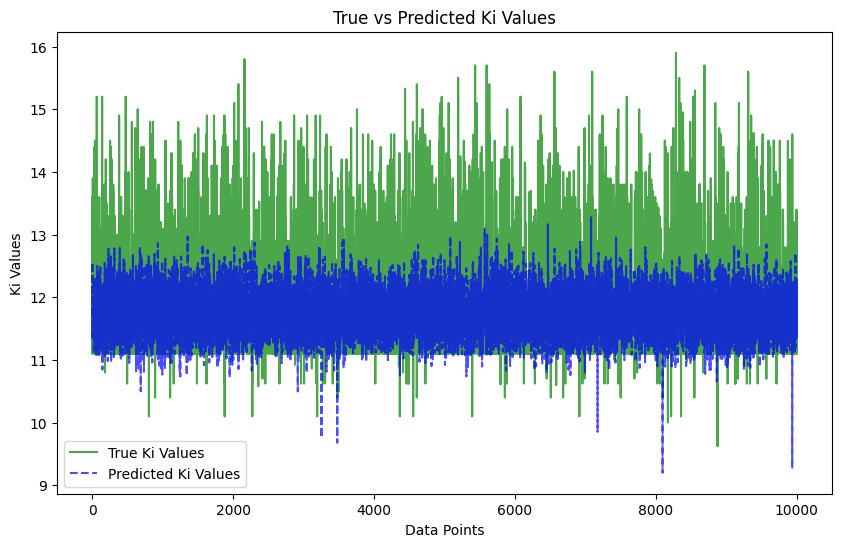

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define lists to store true and predicted Ki values
true_values = []
predicted_values = []

# Testing phase to collect true and predicted Ki values
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for evaluation
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        ki_values = batch['ki_value'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)

        # Collect true and predicted values
        true_values.extend(ki_values.cpu().numpy())  # Convert to CPU and numpy
        predicted_values.extend(outputs.squeeze().cpu().numpy())  # Convert to CPU and numpy

# Convert to numpy arrays for plotting
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)

# Plotting the true vs predicted Ki values
plt.figure(figsize=(10, 6))
plt.plot(true_values, color='green', label='True Ki Values', alpha=0.7)
plt.plot(predicted_values, color='blue', linestyle='--', label='Predicted Ki Values', alpha=0.7)

plt.xlabel('Data Points')
plt.ylabel('Ki Values')
plt.title('True vs Predicted Ki Values')
plt.legend()
plt.show()
